In [1]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
import crlibm
plt.style.use('paper')

In [2]:
Mp = 1.e-8
def makesim(e=0.01, dtOverT = 0.01):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=Mp, P=1., e=e)
    #sim.add(m=Mp, P=2.4, e=0.1)
    sim.move_to_com()
    sim.dt = dtOverT*sim.particles[1].P

    return sim

# Asking IAS15 to integrate to the WHFast integration time to compare is not good enough

WHFast is fundamentally doing an integer number of steps. But each time it does that and updates sim.dt += dt, it's accumulating roundoff errors. 

In [44]:
Nout = 1000
tmax = 1e5
simKD = makesim()
simKD.dt = simKD.particles[1].P*np.sqrt(3)/100.
simKD.integrator="whfast"

sim = makesim()
sim.integrator = "ias15"
times = np.logspace(0, np.log10(tmax), Nout)

xWH, x = np.zeros(Nout), np.zeros(Nout)
for i, time in enumerate(times):
    simKD.integrate(time, exact_finish_time=0)
    sim.integrate(simKD.t)
    xWH[i] = simKD.particles[1].x
    x[i] = sim.particles[1].x

# WHFast reaches machine precision with one particle, but relative error in x grows quadratically

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


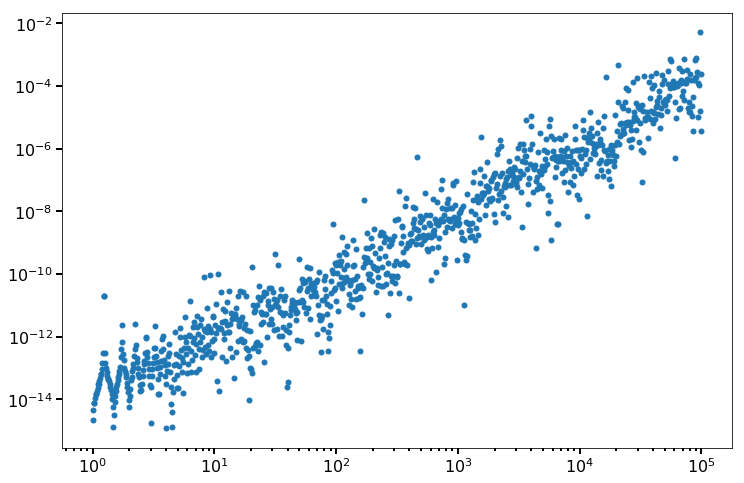

In [45]:
fig, ax = plt.subplots(figsize=(12,8))
ax.loglog(times, np.abs((x-xWH)/x), '.')

# The real time in the WH integration is the number of steps done * sim.dt

We can compare that to sim.t which accumulates error from doing += dt every timestep

In [61]:
Nout = 1000
tmax = 300
simKD = makesim()
simKD.dt = simKD.particles[1].P*np.sqrt(3)/100.
simKD.integrator="whfast"

times = np.logspace(0, np.log10(tmax), Nout)
Nsteps, simt = np.zeros(Nout), np.zeros(Nout)
for i, time in enumerate(times):
    simKD.integrate(time, exact_finish_time=0)
    Nsteps[i] = simKD.steps_done
    simt[i] = simKD.t

# Error is linear

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


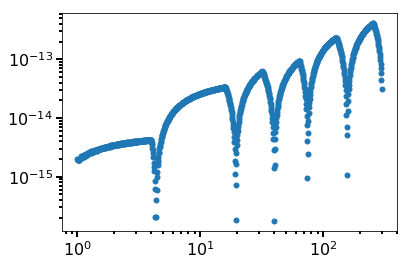

In [63]:
fig, ax = plt.subplots()
ax.loglog(times, np.abs(Nsteps*simKD.dt-simt)/simt, '.')

# Right Way

Integrate IAS15 to simWH.steps_done x simWH.dt, which is the exact time. If you care about the exact times, you could store times[i] = simKD.steps_done x simKD.dt

In [60]:
Nout = 1000
tmax = 1e5
simKD = makesim()
simKD.dt = simKD.particles[1].P*np.sqrt(3)/100.
simKD.integrator="whfast"

sim = makesim()
sim.integrator = "ias15"

times = np.logspace(0, np.log10(tmax), Nout)
xWH, x = np.zeros(Nout), np.zeros(Nout)
for i, time in enumerate(times):
    simKD.integrate(time, exact_finish_time = 0)
    sim.integrate(simKD.steps_done*simKD.dt)
    xWH[i] = simKD.particles[1].x
    x[i] = sim.particles[1].x

# Now x (a phase related quantity) grows as t^3/2 as expected from an integrated quaantity derived from an action that's growing as t^1/2

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


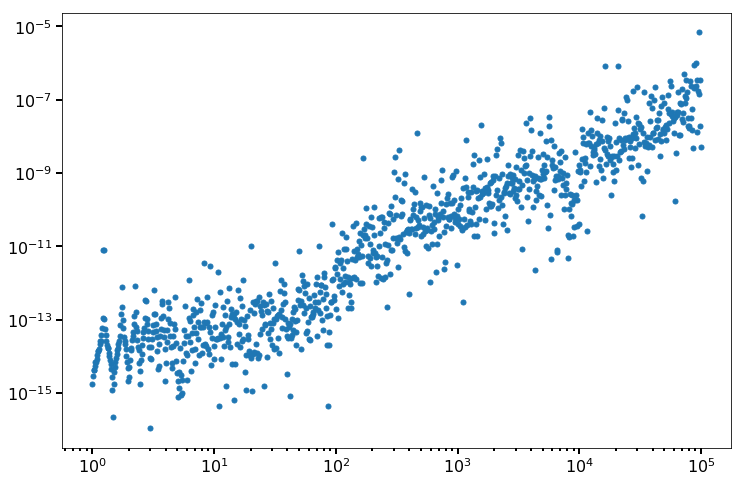

In [56]:
fig, ax = plt.subplots(figsize=(12,8))
ax.loglog(times, np.abs((x-xWH)/x), '.')

In [93]:
alpha = (7./40.)**0.5
beta = 1/48./alpha

def X(sim, kepler, damp, a, b, h):
    kepler.step(sim, -a*h)
    damp.step(sim, b*h)
    kepler.step(sim, a*h)
    return sim

def Z(sim, kepler, damp, a, b, h):
    sim = X(sim, kepler, damp, -a, -b, h)
    sim = X(sim, kepler, damp, a, b, h)
    return sim

def corrector3(sim, kepler, damp, h):
    a1 = -alpha
    a2 = alpha
    b2 = beta/2.
    b1 = -beta/2.
    
    sim = Z(sim, kepler, damp, a2, b2, h)
    sim = Z(sim, kepler, damp, a1, b1, h)
    return sim 

def corrector3inv(sim, kepler, damp, h):
    a1 = -alpha
    a2 = alpha
    b2 = beta/2.
    b1 = -beta/2.
    
    sim = Z(sim, kepler, damp, a1, -b1, h)
    sim = Z(sim, kepler, damp, a2, -b2, h)
    return sim

def run(e=0.1, dt = 0.01, taua = 1000, tmax = 1000., corrector=0):
    simKD = makesim(e=e, dtOverT=dt)
    rebxKD = reboundx.Extras(simKD)
    modKD = rebxKD.load_force("modify_orbits_forces")
    psKD = simKD.particles
    psKD[1].params['tau_a'] = -taua

    simKD.integrator = "none"
    keplerKD = rebxKD.load_operator("kepler")
    integforceKD = rebxKD.load_operator("integrate_force")
    integforceKD.params['force'] = modKD
    integforceKD.params['integrator'] = reboundx.integrators["rk4"]

    rebxKD.add_operator(keplerKD, dt_fraction=1., timing="post")
    rebxKD.add_operator(integforceKD, dt_fraction=1., timing="post")

    sim = makesim(e=e, dtOverT=dt)
    sim.integrator = "ias15"
    rebx = reboundx.Extras(sim)
    mod = rebx.load_force("modify_orbits_forces")
    rebx.add_force(mod)

    ps = sim.particles
    ps[1].params['tau_a'] = -taua

    if corrector == 1:
        keplerKD.step(simKD, simKD.dt/2.)
        simKD.integrate(tmax, exact_finish_time=0)
        keplerKD.step(simKD, -simKD.dt/2.)
    elif corrector == 3:
        simKD = corrector3(simKD, keplerKD, integforceKD, simKD.dt)
        keplerKD.step(simKD, simKD.dt/2.)
        simKD.integrate(tmax, exact_finish_time=0)
        keplerKD.step(simKD, -simKD.dt/2.)
        simKD = corrector3inv(simKD, keplerKD, integforceKD, simKD.dt)
    else:   
        simKD.integrate(tmax, exact_finish_time=0)
    sim.integrate(simKD.steps_done*simKD.dt)
    return np.abs((simKD.calculate_energy()-sim.calculate_energy())/sim.calculate_energy()), sim.particles[1].P

In [86]:
%%time

e=0.1
taua = 10
tmax = 3*taua # initial orbital periods, more since period will decrease
Nout = 100
dts = np.logspace(-0.5, -5, Nout)
Eerrs, Eerrscorr1, Eerrscorr3 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
for i, dt in enumerate(dts):
    Eerrs[i], Pf = run(taua=taua, tmax=tmax, e=e, dt=dt)
    Eerrscorr1[i], Pf = run(taua=taua, tmax=tmax, e=e, dt=dt, corrector=1)
    Eerrscorr3[i], Pf = run(taua=taua, tmax=tmax, e=e, dt=dt, corrector=3)

/Users/dtamayo/Documents/workspace/rebound/rebound/simulation.py:530: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)


CPU times: user 2min 55s, sys: 318 ms, total: 2min 56s
Wall time: 2min 56s


# RK4

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


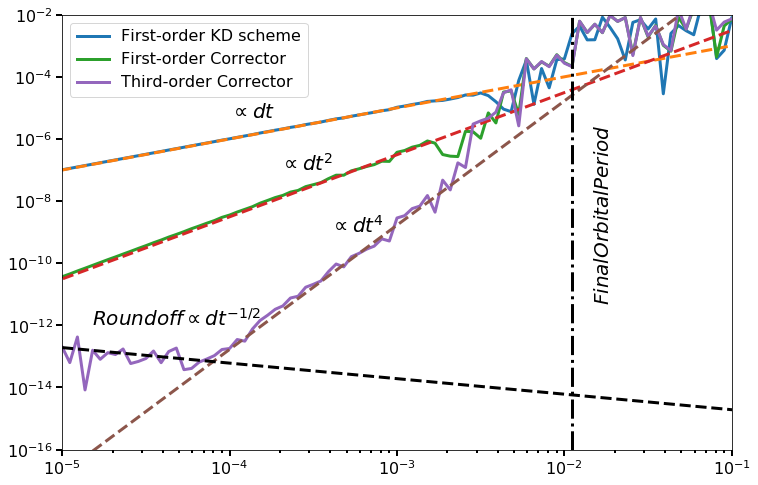

In [87]:
fig, ax = plt.subplots(figsize=(12,8))

mid = int(0.6*Nout)
ax.plot(dts, Eerrs, label='First-order KD scheme')
ax.plot(dts, Eerrs[mid]*dts/dts[mid], '--')
ax.plot(dts, Eerrscorr1, label='First-order Corrector')
ax.plot(dts, Eerrscorr1[mid]*(dts/dts[mid])**2, '--')
ax.plot(dts, Eerrscorr3, label='Third-order Corrector')
ax.plot(dts, Eerrscorr3[mid]*(dts/dts[mid])**4, '--')
ax.plot(np.logspace(-5, 0, 10), 2.**(-53)*(tmax/np.logspace(-5, 0, 10))**0.5, '--', c='k')
ax.text(1.e-4, 5.e-6, r'$\propto dt$', fontsize=20)
ax.text(2.e-4, 1.e-7, r'$\propto dt^2$', fontsize=20)
ax.text(4.e-4, 1.e-9, r'$\propto dt^4$', fontsize=20)
ax.text(1.5e-5, 1.e-12, r'$Roundoff \propto dt^{-1/2}$', fontsize=20)
ax.text(1.5e-2, 1.e-6, r'$Final Orbital Period$', fontsize=20, rotation=90)
ax.axvline(Pf, c='k', linestyle='-.')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1.e-16, 1.e-2])
ax.set_xlim([1.e-5, 1.e-1])
ax.legend()
fig.savefig('dampingcorrectors.pdf', bbox_inches='tight')

# Implement higher order correctors, test with multiple planets (3 operator correctors?)

In [88]:
Nout = 1000
e=0.1
dtOverT = 0.001
taua = 100
tmax = 300

times = np.logspace(0, np.log10(tmax), Nout)

simKD = makesim(e=e, dtOverT=dtOverT)
rebxKD = reboundx.Extras(simKD)
modKD = rebxKD.load_force("modify_orbits_forces")
rebxKD.add_force(modKD)
psKD = simKD.particles
psKD[1].params['tau_a'] = -taua

simKD.integrator = "none"
keplerKD = rebxKD.load_operator("kepler")
integforceKD = rebxKD.load_operator("integrate_force")
integforceKD.params['force'] = modKD
integforceKD.params['integrator'] = reboundx.integrators["rk4"]

rebxKD.add_operator(keplerKD, dt_fraction=1., timing="post")
rebxKD.add_operator(integforceKD, dt_fraction=1., timing="post")

sim = makesim(e=e, dtOverT=dtOverT)
sim.integrator = "ias15"
rebx = reboundx.Extras(sim)
mod = rebx.load_force("modify_orbits_forces")
rebx.add_force(mod)

ps = sim.particles
ps[1].params['tau_a'] = -taua

EsKD, EsMDE, Es = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
fKD, fMDE, f = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
P = np.zeros(Nout)
dEs, cumdEs = np.zeros(Nout), np.zeros(Nout)
E0 = simKD.calculate_energy()

for i, time in enumerate(times):
    simKD = corrector3(simKD, keplerKD, integforceKD, simKD.dt)
    keplerKD.step(simKD, simKD.dt/2.)
    simKD.integrate(time, exact_finish_time=0)
    keplerKD.step(simKD, -simKD.dt/2.)
    simKD = corrector3inv(simKD, keplerKD, integforceKD, simKD.dt) 
    sim.integrate(simKD.steps_done*simKD.dt)
    Es[i] = sim.calculate_energy()
    EsKD[i] = simKD.calculate_energy()
    fKD[i] = simKD.particles[1].f
    f[i] = sim.particles[1].f
    P[i] = sim.particles[1].P

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


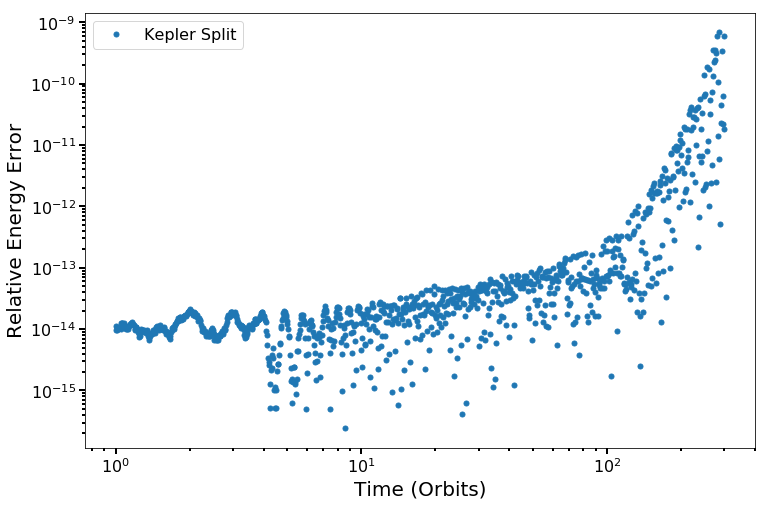

In [89]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, np.abs((EsKD-Es)/Es), '.', label='Kepler Split')
#ax.plot(times, np.abs((EsMDE-Es)/Es), '.', label='Error Estimate')

ax.set_xscale('log')
ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-8, 1])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

In [115]:
%%time
Nout = 1000
e=0.1
dtOverT = 0.001
taua = 1000
tmax = 1000

times = np.linspace(0, tmax, Nout)

simKD = makesim(e=e, dtOverT=dtOverT)
rebxKD = reboundx.Extras(simKD)
modKD = rebxKD.load_force("modify_orbits_forces")
rebxKD.add_force(modKD)
psKD = simKD.particles
psKD[1].params['tau_a'] = -taua

simKD.integrator = "none"
keplerKD = rebxKD.load_operator("kepler")
integforceKD = rebxKD.load_operator("integrate_force")
integforceKD.params['force'] = modKD
integforceKD.params['integrator'] = reboundx.integrators["rk4"]

rebxKD.add_operator(keplerKD, dt_fraction=0.5, timing="post")
rebxKD.add_operator(integforceKD, dt_fraction=1., timing="post")
rebxKD.add_operator(keplerKD, dt_fraction=0.5, timing="post")

sim = makesim(e=e, dtOverT=dtOverT)
sim.integrator = "ias15"
rebx = reboundx.Extras(sim)
mod = rebx.load_force("modify_orbits_forces")
rebx.add_force(mod)

ps = sim.particles
ps[1].params['tau_a'] = -taua

simMDE = makesim(e=e, dtOverT=dtOverT)
simMDE.integrator = "ias15"
rebxMDE = reboundx.Extras(simMDE)
modMDE = rebxMDE.load_force("modify_orbits_forces")
rebxMDE.add_force(modMDE)

keplerMDE = rebxMDE.load_operator("kepler")
integforceMDE = rebxMDE.load_operator("integrate_force")
integforceMDE.params['force'] = modMDE
integforceMDE.params['integrator'] = reboundx.integrators["rk4"]

simMDE.particles[1].params['tau_a'] = -taua


EsKD, EsMDE, Es = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
fKD, fMDE, f = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
P = np.zeros(Nout)
dEs, cumdEs = np.zeros(Nout), np.zeros(Nout)
E0 = simKD.calculate_energy()
cumdEMDE = np.zeros(Nout)

for i, time in enumerate(times):
    simKD.integrate(time, exact_finish_time=0)
    sim.integrate(simKD.steps_done*simKD.dt)
    Es[i] = sim.calculate_energy()
    EsKD[i] = simKD.calculate_energy()
    
    E0 = simMDE.calculate_energy()
    simMDE = corrector3inv(simMDE, keplerMDE, integforceMDE, simKD.dt) 
    E1 = simMDE.calculate_energy()
    if i == 0:
        cumdEMDE[i] = (E1 - E0)
    else:
        cumdEMDE[i] = cumdEMDE[i-1] + (E1 - E0)
    simMDE.integrate(simKD.steps_done*simKD.dt)
    E0 = simMDE.calculate_energy()
    simMDE = corrector3(simMDE, keplerMDE, integforceMDE, simKD.dt)
    E1 = simMDE.calculate_energy()
    if i == 0:
        cumdEMDE[i] = (E1 - E0)
    else:
        cumdEMDE[i] = cumdEMDE[i-1] + (E1 - E0)
        
    EsMDE[i] = simMDE.calculate_energy()
    
    fKD[i] = simKD.particles[1].f
    f[i] = sim.particles[1].f
    P[i] = sim.particles[1].P

CPU times: user 3.66 s, sys: 3.97 ms, total: 3.67 s
Wall time: 3.67 s


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


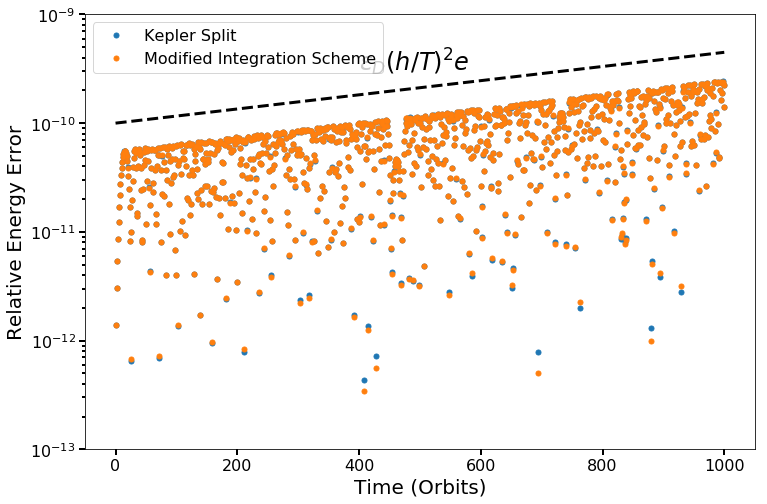

In [127]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, np.abs((EsKD-Es)/Es), '.', label='Kepler Split')
ax.plot(times, np.abs((EsMDE-Es)/Es), '.', label='Modified Integration Scheme')
ax.plot(times, P/taua *(simKD.dt/P)**2 * e, 'k--')
ax.text(400, 3.e-10, r'$\epsilon_D (h/T)^2e$', fontsize=24)
ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
ax.set_ylim([1e-13, 1e-9])
ax.legend()
fig.savefig("damping.pdf", bbox_inches='tight')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


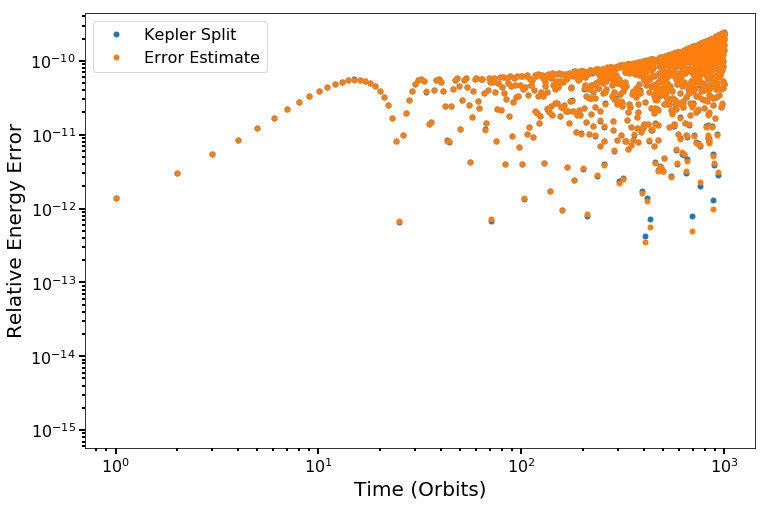

In [117]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, np.abs((EsKD-Es)/Es), '.', label='Kepler Split')
ax.plot(times, np.abs((EsMDE-Es)/Es), '.', label='Error Estimate')

ax.set_xscale('log')
ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-8, 1])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


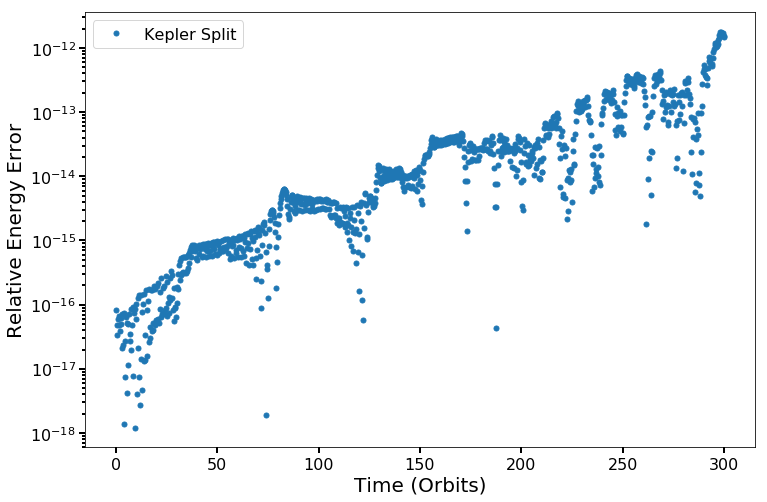

In [111]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, np.abs(cumdEMDE), '.', label='Kepler Split')

ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-8, 1])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

In [112]:
%%time
Nout = 1000
e=0.1
dtOverT = 0.001
#taua = 10
tmax = 300

times = np.linspace(0, tmax, Nout)

simKD = makesim(e=e, dtOverT=dtOverT)
simKD.integrator = "whfast"
rebxKD = reboundx.Extras(simKD)
grKD = rebxKD.load_force("gr_potential")
rebxKD.add_force(grKD)
grKD.params['c'] = 1.e4

sim = makesim(e=e, dtOverT=dtOverT)
sim.integrator = "ias15"
rebx = reboundx.Extras(sim)
gr = rebx.load_force("gr_potential")
rebx.add_force(gr)
gr.params['c'] = 1.e4

simMDE = makesim(e=e, dtOverT=dtOverT)
simMDE.integrator = "ias15"
rebxMDE = reboundx.Extras(simMDE)
grMDE = rebxMDE.load_force("gr_potential")
rebxMDE.add_force(grMDE)
grMDE.params['c'] = 1.e4

keplerMDE = rebxMDE.load_operator("kepler")
integforceMDE = rebxMDE.load_operator("integrate_force")
integforceMDE.params['force'] = grMDE
integforceMDE.params['integrator'] = reboundx.integrators["euler"]

EsKD, EsMDE, Es = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
fKD, fMDE, f = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
P = np.zeros(Nout)
dEs, cumdEs = np.zeros(Nout), np.zeros(Nout)
E0 = simKD.calculate_energy()
cumdEMDE = np.zeros(Nout)

for i, time in enumerate(times):
    simKD.integrate(time, exact_finish_time=0)
    sim.integrate(simKD.steps_done*simKD.dt)
    Es[i] = sim.calculate_energy()
    EsKD[i] = simKD.calculate_energy()
    
    E0 = simMDE.calculate_energy()
    simMDE = corrector3inv(simMDE, keplerMDE, integforceMDE, simKD.dt) 
    E1 = simMDE.calculate_energy()
    if i == 0:
        cumdEMDE[i] = (E1 - E0)
    else:
        cumdEMDE[i] = cumdEMDE[i-1] + (E1 - E0)
    simMDE.integrate(simKD.steps_done*simKD.dt)
    E0 = simMDE.calculate_energy()
    simMDE = corrector3(simMDE, keplerMDE, integforceMDE, simKD.dt)
    E1 = simMDE.calculate_energy()
    if i == 0:
        cumdEMDE[i] = (E1 - E0)
    else:
        cumdEMDE[i] = cumdEMDE[i-1] + (E1 - E0)
        
    EsMDE[i] = simMDE.calculate_energy()
    
    fKD[i] = simKD.particles[1].f
    f[i] = sim.particles[1].f
    P[i] = sim.particles[1].P

CPU times: user 427 ms, sys: 1.91 ms, total: 429 ms
Wall time: 427 ms


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


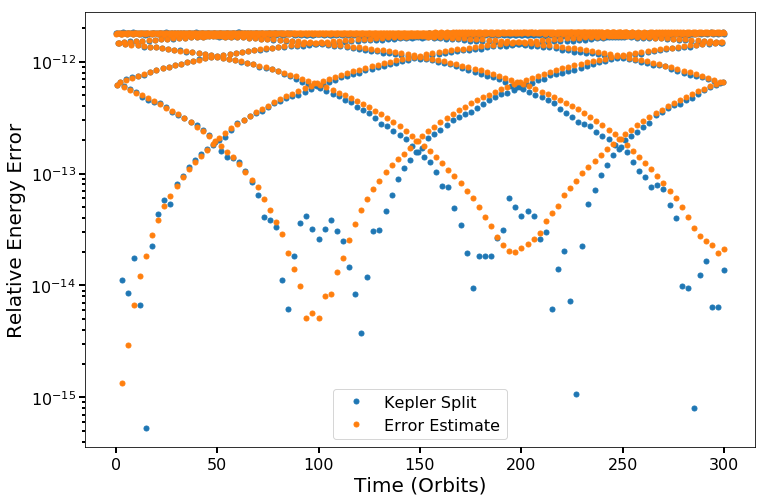

In [113]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, np.abs((EsKD-Es)/Es), '.', label='Kepler Split')
ax.plot(times, np.abs((EsMDE-Es)/Es), '.', label='Error Estimate')

ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-8, 1])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


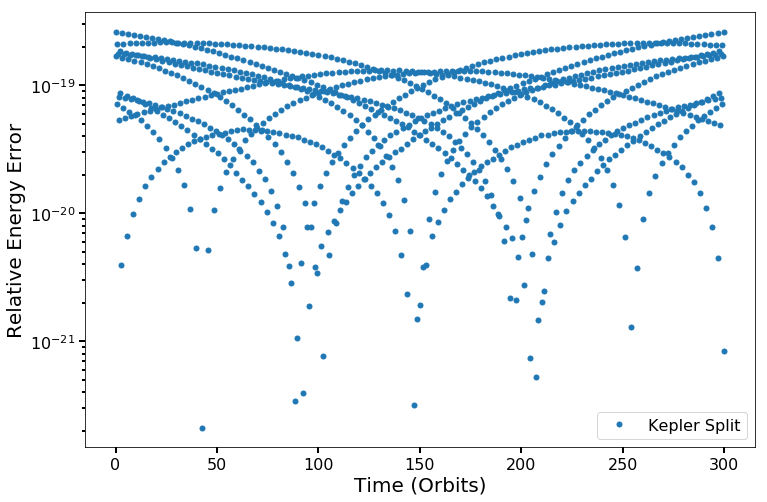

In [114]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, np.abs(cumdEMDE), '.', label='Kepler Split')

ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-8, 1])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

In [44]:
P[-1]

0.2226270316208364

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


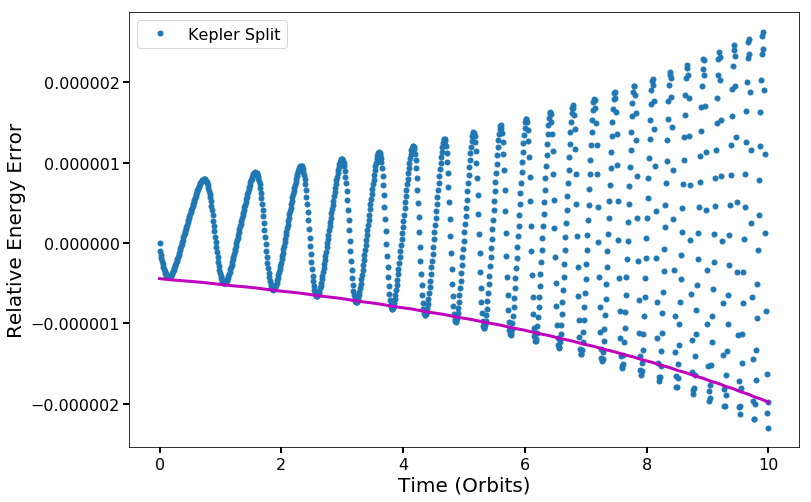

In [46]:
signedEerr = (EsKD-Es)/np.abs(Es)
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, signedEerr, '.', label='Kepler Split')
ax.plot(times, signedEerr[-1]*P[-1]/P, 'm')
#ax.plot(times, np.abs((EsMDE-Es)/Es), '.', label='Error Estimate')

#ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([-1e-5, -1e-3])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


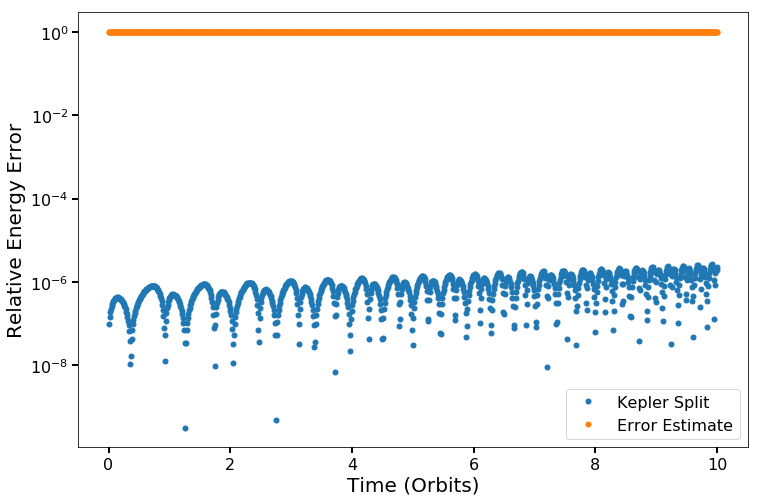

In [47]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, np.abs((EsKD-Es)/Es), '.', label='Kepler Split')
ax.plot(times, np.abs((EsMDE-Es)/Es), '.', label='Error Estimate')

ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-8, 1])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

In [ ]:
def damp_crlibm_exp(reb_sim, rebx_operator, dt):
    sim = reb_sim.contents
    p = sim.particles[1]
    fac = crlibm.exp_rd(sim.dt/2./p.params['tau_a'])
    p.vx = p.vx*fac
    p.vy = p.vy*fac
    p.vz = p.vz*fac

def damp_crlibm_expm1(reb_sim, rebx_operator, dt):
    sim = reb_sim.contents
    p = sim.particles[1]
    corr = crlibm.expm1_rd(sim.dt/2./p.params['tau_a'])
    p.vx += p.vx*corr
    p.vy += p.vy*corr
    p.vz += p.vz*corr

def damp(reb_sim, rebx_operator, dt):
    sim = reb_sim.contents
    p = sim.particles[1]
    fac = np.exp(sim.dt/2./p.params['tau_a'])
    p.vx = p.vx*fac
    p.vy = p.vy*fac
    p.vz = p.vz*fac

def damp_diff_expansion(reb_sim, rebx_operator, dt):
    sim = reb_sim.contents
    p = sim.particles[1]
    for i in range(1,6):
        fac = (sim.dt/2./p.params['tau_a'])**i/math.factorial(i)
        p.vx += p.vx*fac
        p.vy += p.vy*fac
        p.vz += p.vz*fac



/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
No handles with labels found to put in legend.


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


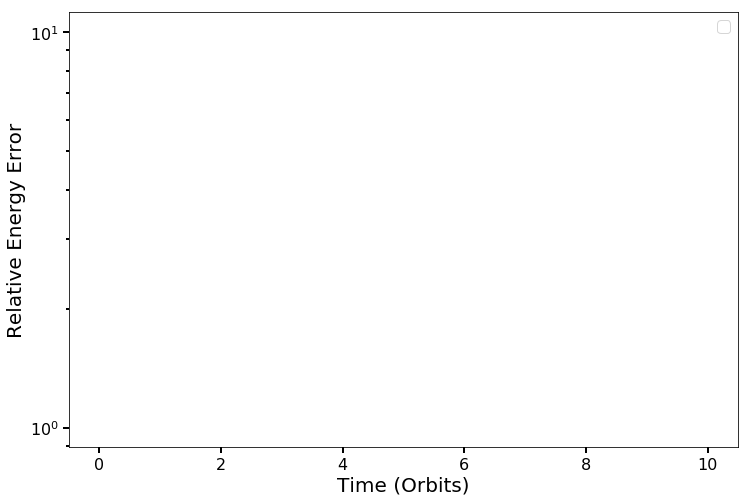

In [48]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, dEs, '.')

ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-8, 1])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

No handles with labels found to put in legend.


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


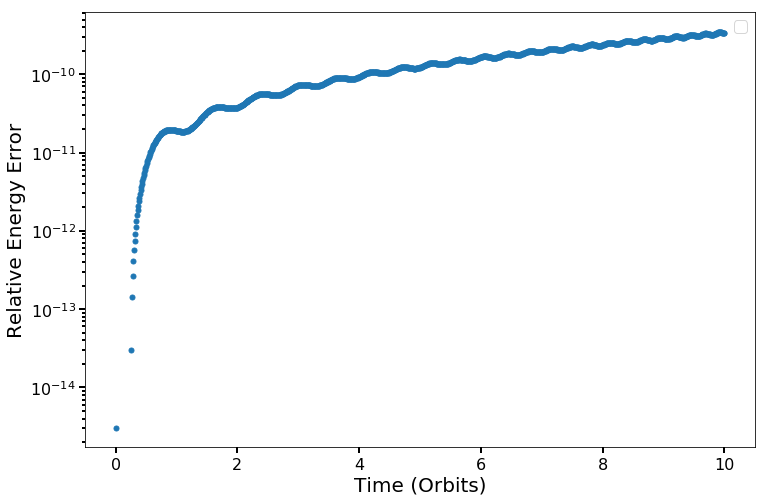

In [50]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, cumdEs, '.')

ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-8, 1])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')